In [65]:
%%writefile app.py

import os
import streamlit as st
import numpy as np
from PIL import  Image

from multipage import MultiPage
from pages import upload, compare, inspect, alignment, info, heatmap

app = MultiPage()

# Main page
img = 'corona.png'
display = Image.open(img)
col1, col2 = st.columns(2)
col1.image(display, width = 200)
col2.title('Corona viz')

app.add_page('Upload Data', upload.app)
app.add_page('Compare against corona lineages', compare.app)
app.add_page('Inspect mutations', inspect.app)
app.add_page('Alignment information', alignment.app)
app.add_page('Sequence information', info.app)
app.add_page('Heatmap', heatmap.app)


app.run()




Overwriting app.py


In [120]:
%%writefile multipage.py
import streamlit as st

class MultiPage: 
    def __init__(self) -> None:
        self.pages = []
    
    def add_page(self, title, func) -> None: 
        self.pages.append({"title": title, "function": func})

    def run(self):
        page = st.sidebar.selectbox('Navigation', self.pages, format_func=lambda page: page['title'])
        page['function']()


Overwriting multipage.py


In [251]:
%%writefile pages/compare.py
import streamlit as st
import altair as alt
from corona_viz.plotting import CoronaPlot
from corona_viz.nextclade import Nextclade

def app():
    nextclade = Nextclade()
    corona = CoronaPlot(nextclade.QUERY, nextclade.REF, 'mutations.csv')
    df = nextclade.make_meta_df()
    pango_line = df.Nextclade_pango.values[0]
    clade = df.clade.values[0]
    df = nextclade.make_meta_df()
    name = df.seqName.values[0]

    st.markdown(f'##### Compare {name} to other lineages')
    st.markdown(f'**Predicted pangolin and clade:** {pango_line} | {clade}')
    compare_to = corona.dataframes.make_mutations_df()
    pango = st.selectbox('Select pango lineage to compare with', sorted(compare_to['pango'].unique()))
    compare_plot = corona.plot_compare(pango)
    st.altair_chart(compare_plot)
    

Overwriting pages/compare.py


In [39]:
%%writefile pages/upload.py
import streamlit as st
from corona_viz.nextclade import Nextclade

def app():
    st.title('Upload file')
    fasta = st.file_uploader("FASTA file to run Nextclade on")
    if fasta is not None:
        st.markdown('#### Running Nextclade on the fasta file... Please wait a second.')
        with open('input.fasta', 'w+') as f:
            print(fasta.read().decode(), file=f)
            
        nextclade = Nextclade()
        nextclade.run_nextclade()
        st.markdown('##### Nextclade done!')
        #nextclade.make_meta_df()
        #st.write(nextclade.meta_df)


Overwriting pages/upload.py


In [184]:
%%writefile pages/inspect.py
import streamlit as st
import altair as alt
from corona_viz.plotting import CoronaPlot
from corona_viz.nextclade import Nextclade

def app():
    nextclade = Nextclade()
    corona = CoronaPlot(nextclade.QUERY, nextclade.REF, 'mutations.csv')
    df = nextclade.make_meta_df()
    name = df.seqName.values[0]
    
    st.markdown(f'### Inspect mutations in {name}')
    inspect = corona.plot_mutations_inspection()
    st.altair_chart(inspect)

Overwriting pages/inspect.py


In [185]:
%%writefile pages/alignment.py
import streamlit as st
import altair as alt
from corona_viz.plotting import CoronaPlot
from corona_viz.nextclade import Nextclade

# Make the gene map above the smaller graph. Use position and a mark_rect with a heigth to plot the genes.

def app():
    nextclade = Nextclade()
    corona = CoronaPlot(nextclade.QUERY, nextclade.REF, 'mutations.csv')
    df = nextclade.make_meta_df()
    name = df.seqName.values[0]
    
    st.markdown(f'### Alignment of {name}')
    a, b = corona.plot_alignment_map()
    st.altair_chart((a & b))

Overwriting pages/alignment.py


In [263]:
%%writefile pages/heatmap.py
import streamlit as st
import altair as alt
from corona_viz.plotting import CoronaPlot
from corona_viz.nextclade import Nextclade

# Cluster the heatmap in another way

def app():
    nextclade = Nextclade()
    corona = CoronaPlot(nextclade.QUERY, nextclade.REF, 'mutations.csv')
    
    st.markdown('### Heatmap of mutations in all lineages')
    heatmap = corona.plot_mutation_heatmap()
    st.altair_chart(heatmap)
    

Overwriting pages/heatmap.py


In [181]:
%%writefile pages/info.py
import streamlit as st
from corona_viz.nextclade import Nextclade

def app():
    nextclade = Nextclade()
    df = nextclade.make_meta_df()
    pango = df.Nextclade_pango.values[0]
    clade = df.clade.values[0]
    overall = df['qc.overallStatus'].values[0].title()
    missing = df['qc.missingData.totalMissing'].values[0]
    substitutions = df['totalSubstitutions'].values[0]
    deletions = df['totalDeletions'].values[0]
    amino_sub = df['totalAminoacidSubstitutions'].values[0]
    amino_del = df['totalAminoacidDeletions'].values[0]
    reversion = str(df['privateNucMutations.reversionSubstitutions'].values[0]).split(',')
    labeled = str(df['privateNucMutations.labeledSubstitutions'].values[0]).split(',')
    unlabeled = str(df['privateNucMutations.unlabeledSubstitutions'].values[0]).split(',')

    st.markdown(f'### {df.seqName.values[0]}')
    st.markdown("""---""")

    col1, col2 = st.columns(2)
    
    col1.metric('Clade', f'{clade}')
    col2.metric('Pangolin', f'{pango}')
    
    col1.metric('Alignment score', f'{overall}')
    col2.metric('Missing nucleotides', f'{missing}')
    
    col1.metric('Total nt substitutions', f'{substitutions}')
    col2.metric('Total nt deletions', f'{deletions}')
    
    col1.metric('Total AA substitutions', f'{amino_sub}')
    col2.metric('Total AA deletions', f'{amino_del}')
    
    col1, col2, col3 = st.columns(3)
    col1.markdown('##### Reversion mutations')
    [col1.markdown(x) for x in reversion]
    col2.markdown('##### Labeled mutations')
    [col2.markdown(x) for x in labeled]
    col3.markdown('##### Novel mutations')
    [col3.markdown(x) for x in unlabeled]

    st.markdown("""---""")



Overwriting pages/info.py


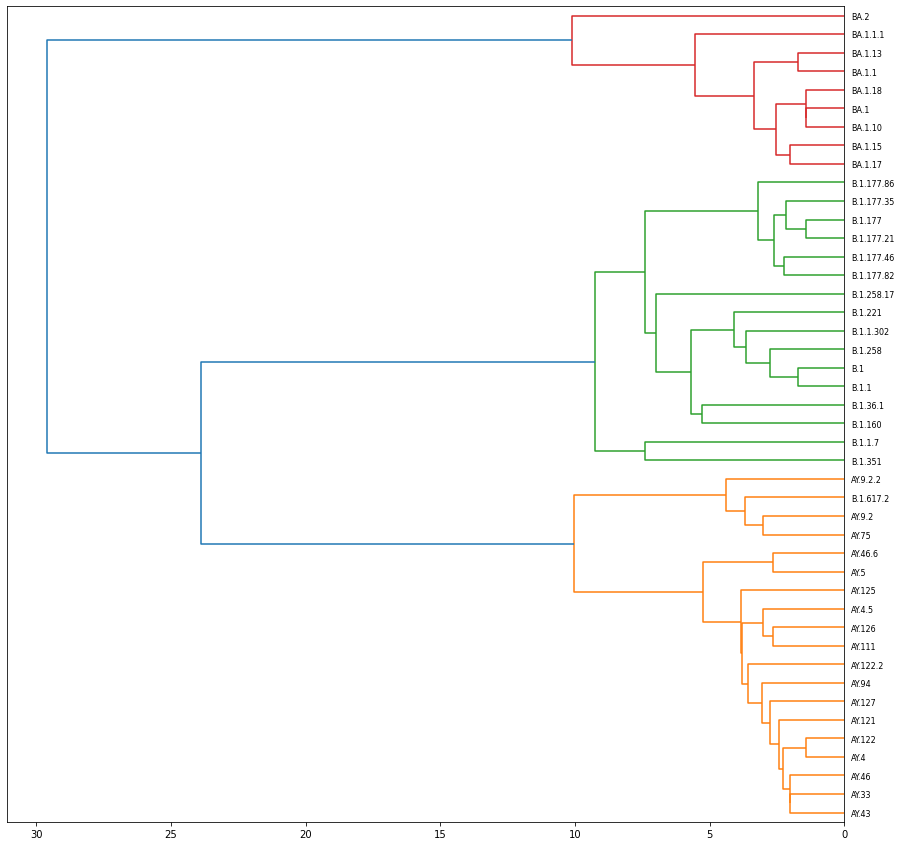

In [260]:
import pandas as pd
import numpy as np

mutations = pd.read_csv('mutations.csv')
mutations['present'] = np.ceil(mutations['ratio'])
mutations_wide = mutations.pivot(index='pango', columns='mutation', values='present')
mutations_wide.fillna(0, inplace=True)
mutations_wide.reset_index(inplace=True)
df = mutations_wide.iloc[:, 1:]

from scipy.cluster.hierarchy import linkage, dendrogram 
from matplotlib import pyplot as plt

linked = linkage(df.to_numpy(), method='ward', metric='euclidean', optimal_ordering=True)

plt.figure(figsize=(15, 15))

fig = dendrogram(linked,
            orientation='left',
            distance_sort='descending',
            show_leaf_counts=True,
           labels=list(mutations_wide.pango))


In [ ]:
import pandas as pd
import numpy as np
import dash_bio as dashbio

mutations = pd.read_csv('mutations.csv')
mutations['present'] = np.ceil(mutations['ratio'])
mutations_wide = mutations.pivot(index='pango', columns='mutation', values='present')
mutations_wide.fillna(0, inplace=True)
mutations_wide.reset_index(inplace=True)
df = mutations_wide.iloc[:, 1:]

columns = list(df.columns.values)
rows = list(df.index)

clustergram = dashbio.Clustergram(
data=df.loc[rows].values,
row_labels=rows,
column_labels=columns,
color_threshold={
    'row': 250,
    'col': 700
},
height=800,
width=700,
hidden_labels='row'
)

st.plotly_chart(clustergram)